In [8]:
from trainValTestGreyscale import getData
import logging
import os
import sys
import tempfile
from glob import glob
from natsort import natsorted
import random
import torch
from PIL import Image
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import monai
from monai.data import create_test_image_2d, list_data_collate, decollate_batch
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.transforms import (
    Activations,
    AddChanneld,
    AsDiscrete,
    Compose,
    LoadImaged,
    RandCropByPosNegLabeld,
    RandRotate90d,
    RandFlipd,
    Rand2DElasticd,
    ScaleIntensityd,
    EnsureTyped,
    EnsureType,
    RandGaussianNoised
)
from monai.visualize import plot_2d_or_3d_image
from monai.transforms import Activations, AddChanneld, AsDiscrete, Compose, LoadImaged, SaveImage, ScaleIntensityd, EnsureTyped, EnsureType, KeepLargestConnectedComponent, FillHoles
from monai.networks.nets import UNet
import warnings
from typing import Sequence, Union

import torch

from monai.metrics.utils import do_metric_reduction, ignore_background
from monai.utils import MetricReduction, ensure_tuple
from monai.metrics import confusion_matrix
from monai.metrics import CumulativeIterationMetric

In [9]:
# Get Data
_, _, val_images, val_segs, test_images, test_segs = getData.getImageSegTrainValTest("ALL")

test_files = [{"img": img, "seg": seg}
                for img, seg in zip(test_images, test_segs)]

test_transforms = Compose(
    [
        LoadImaged(keys=["img", "seg"]),
        AddChanneld(keys=["img", "seg"]),
        ScaleIntensityd(keys=["img", "seg"]),
        EnsureTyped(keys=["img", "seg"]),
    ]
)
#Setup DataLoader
test_ds = monai.data.Dataset(data=test_files, transform=test_transforms)
test_loader = DataLoader(test_ds, batch_size=1,
                        num_workers=4, collate_fn=list_data_collate)
dice_metric = DiceMetric(include_background=False,
                          reduction="mean", get_not_nans=False)



post_trans = Compose([EnsureType(), Activations(
        sigmoid=True), AsDiscrete(threshold=0.5),KeepLargestConnectedComponent(applied_labels = [1], independent = True, connectivity = 2)]) #,FillHoles(connectivity = 2, applied_labels = [1]),KeepLargestConnectedComponent(applied_labels = [1], independent = True, connectivity = 2)
#saver = SaveImage(output_dir="./output",
                  #output_ext=".png", output_postfix="seg")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

model.load_state_dict(torch.load(
    "ALL_4l_rotFlip_1000epochs.pth"))

#print(model)


<All keys matched successfully>

In [10]:
#Evaluation loop
FP = 0
FN = 0
TP = 0
TN = 0
dice_metric.reset()
model.eval()

with torch.no_grad():
    i = 0
    for test_data in test_loader:
        test_images, test_labels = test_data["img"].to(
            device), test_data["seg"].to(device)
        test_outputs = model(test_images)
        test_outputs = [post_trans(i) for i in decollate_batch(test_outputs)]
        test_labels = decollate_batch(test_labels)
        # compute metric for current iteration
        dice_metric(y_pred=test_outputs, y=test_labels)

        test_outputs = test_outputs[0].cpu().detach().numpy()
        test_labels = test_labels[0].cpu().detach().numpy()
        FP += len(np.where(test_outputs - test_labels == -1)[0])
        FN += len(np.where(test_outputs - test_labels == 1)[0])
        TP += len(np.where(test_outputs + test_labels == 2)[0])
        TN += len(np.where(test_outputs + test_labels == 0)[0])
        
    # aggregate the final mean dice result
    print("Dice score:", dice_metric.aggregate().item())

    # reset the status
    dice_metric.reset()

Dice score: 0.9025728702545166


In [11]:
total = FP+FN + TP + TN
print(FP/total)
print(FN/total)
print(TP/total)
print(TN/total)
accuracy = (TP + TN)/(FP+FN+TP+TN) 
precision = TP/(TP+FP)
recall = TP/(TP+FN)
f1 = 2*(precision*recall)/(precision+recall)
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("f1-score: ", f1)

0.007262978738281702
0.0016674010695960804
0.043939548290961
0.9471300719011613
Accuracy:  0.9910696201921222
Precision:  0.8581519475760702
Recall:  0.9634397587873281
f1-score:  0.9077530409118223


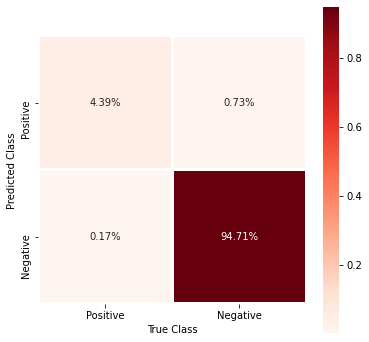

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
cmat = [[TP, FP], [FN, TN]]

plt.figure(figsize = (6,6))
x_labels = ["Positive", "Negative"]
y_labels = ["Positive", "Negative"]
sns.heatmap(cmat/np.sum(cmat), cmap="Reds", annot=True, fmt = '.2%', square=1,   linewidth=2.,
  xticklabels = x_labels, yticklabels = y_labels)
plt.xlabel("True Class")
plt.ylabel("Predicted Class")
plt.show()

In [13]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import logging
import os
import sys
import tempfile
from glob import glob

import torch
from PIL import Image
from torch.utils.data import DataLoader
from natsort import natsorted

import monai
from monai.data import create_test_image_2d, list_data_collate, decollate_batch
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import UNet
from monai.transforms import Activations, AddChanneld, AsDiscrete, Compose, LoadImaged, SaveImage, ScaleIntensityd, EnsureTyped, EnsureType


def main(tempdir):
    monai.config.print_config()
    logging.basicConfig(stream=sys.stdout, level=logging.INFO)

    path_to_grey_img = r"greyscale"
    path_to_grey_seg = r"greyscale_out"

    #images = natsorted(glob(os.path.join(path_to_grey_img, "IMG*.tiff")))
    #segs = natsorted(glob(os.path.join(path_to_grey_seg, "I0*.tiff")))

    _, _, val_images, val_segs, test_images, test_segs = getData.getImageSegTrainValTest("0")

    val_files = [{"img": img, "seg": seg} for img, seg in zip(val_images, val_segs)]

    # define transforms for image and segmentation
    val_transforms = Compose(
        [
            LoadImaged(keys=["img", "seg"]),
            AddChanneld(keys=["img", "seg"]),
            ScaleIntensityd(keys=["img", "seg"]),
            EnsureTyped(keys=["img", "seg"]),
        ]
    )
    val_ds = monai.data.Dataset(data=val_files, transform=val_transforms)
    # sliding window inference need to input 1 image in every iteration
    val_loader = DataLoader(val_ds, batch_size=1,
                            num_workers=4, collate_fn=list_data_collate)
    dice_metric = DiceMetric(include_background=False,
                             reduction="mean", get_not_nans=False)
    post_trans = Compose([EnsureType(), Activations(
        sigmoid=True), AsDiscrete(threshold=0.5)])
    saver = SaveImage(output_dir="./output",
                      output_ext=".png", output_postfix="seg")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = UNet(
        spatial_dims=2,
        in_channels=1,
        out_channels=1,
        channels=(16, 32, 64, 128, 256),
        strides=(2, 2, 2, 2),
        num_res_units=2,
    ).to(device)

    model.load_state_dict(torch.load(
        "ALL_4l_rotFlip_1000epochs.pth"))

    model.eval()
    with torch.no_grad():
        for val_data in val_loader:
            val_images, val_labels = val_data["img"].to(
                device), val_data["seg"].to(device)
            # define sliding window size and batch size for windows inference
            #roi_size = (192, 192)
            sw_batch_size = 4
            val_output = model(val_images)
            #val_outputs = sliding_window_inference(
                #val_images, roi_size, sw_batch_size, model)
            val_outputs = [post_trans(i) for i in decollate_batch(val_output)]
            val_labels = decollate_batch(val_labels)
            # compute metric for current iteration
            dice_metric(y_pred=val_outputs, y=val_labels)
            for val_output in val_outputs:
                saver(val_output)
        # aggregate the final mean dice result
        print("evaluation metric:", dice_metric.aggregate().item())
        # reset the status
        dice_metric.reset()


if __name__ == "__main__":
    with tempfile.TemporaryDirectory() as tempdir:
        main(tempdir)


MONAI version: 0.8.0
Numpy version: 1.19.3
Pytorch version: 1.8.2+cu111
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 714d00dffe6653e21260160666c4c201ab66511b

Optional dependencies:
Pytorch Ignite version: 0.4.6
Nibabel version: 3.2.2
scikit-image version: 0.19.1
Pillow version: 9.0.1
Tensorboard version: 2.5.0
gdown version: 4.2.1
TorchVision version: 0.9.2+cu111
tqdm version: 4.58.0
lmdb version: 1.3.0
psutil version: 5.8.0
pandas version: 1.1.4
einops version: 0.4.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies

file written: c:\Users\EmilR\Documents\Datalogi\bachelor\temp\output\0\0_seg.png.
file written: c:\Users\EmilR\Documents\Datalogi\bachelor\temp\output\1\1_seg.png.
file written: c:\Users\EmilR\Documents\Datalogi\bachelor\temp\output\2

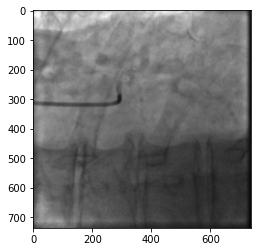

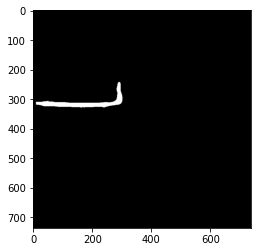

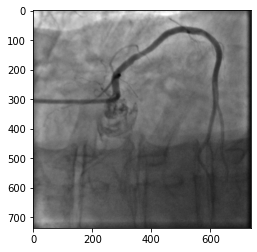

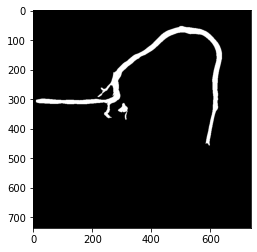

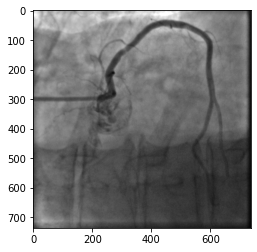

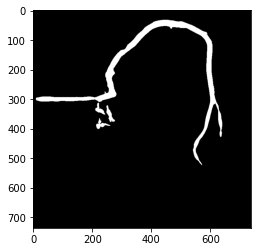

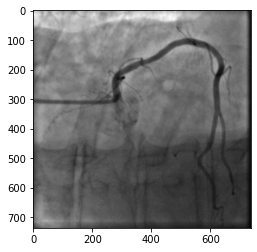

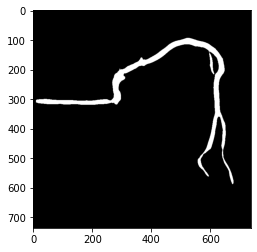

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


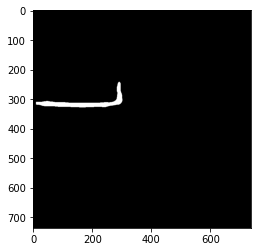

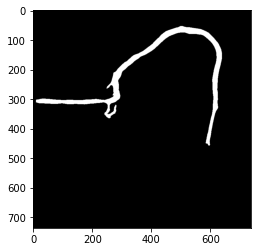

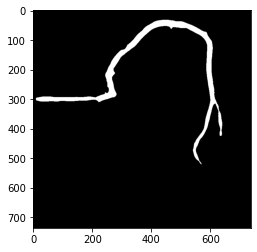

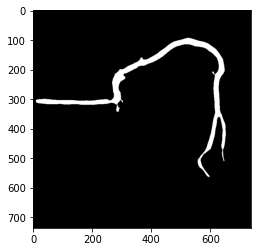

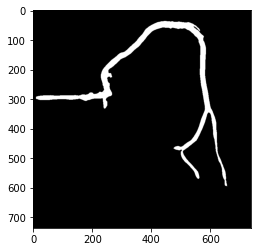

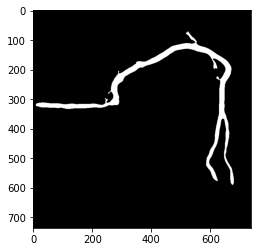

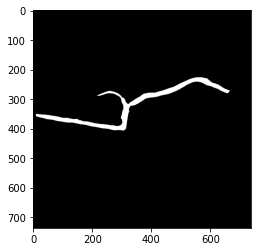

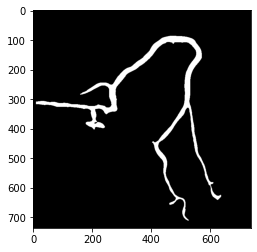

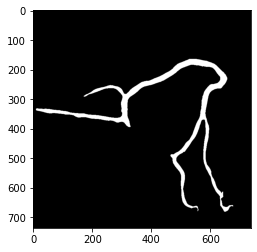

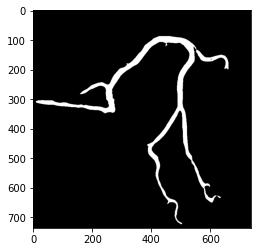

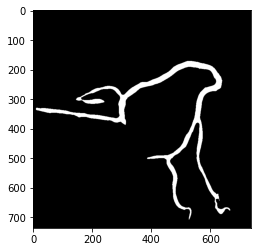

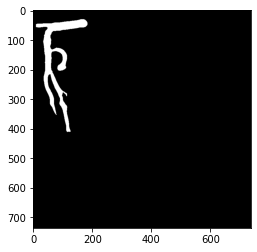

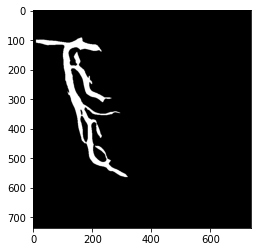

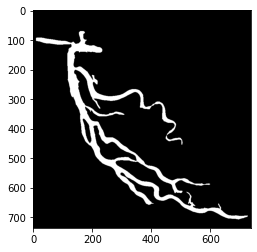

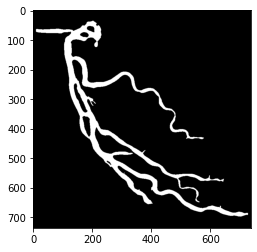

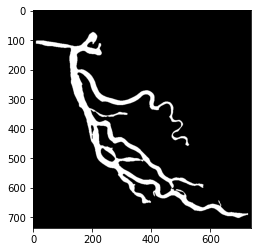

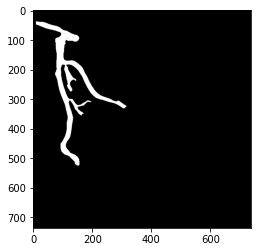

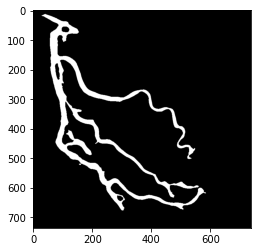

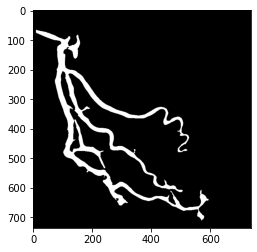

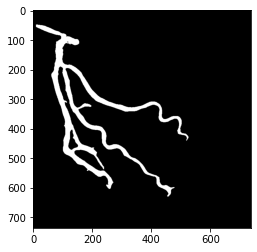

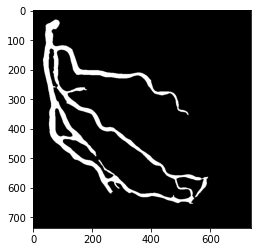

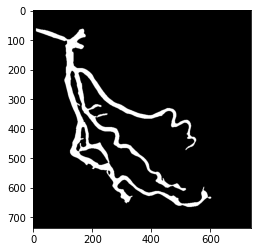

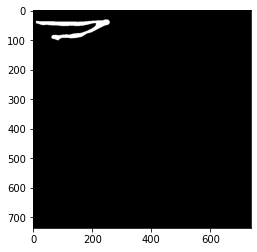

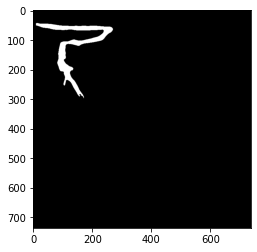

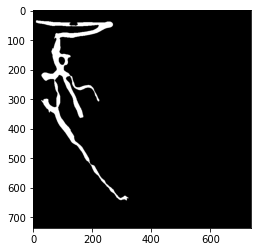

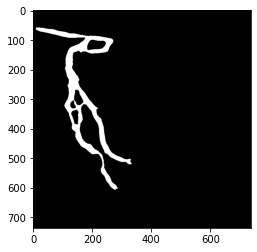

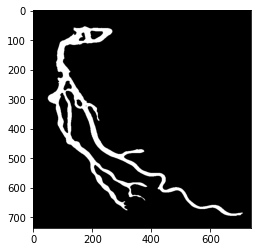

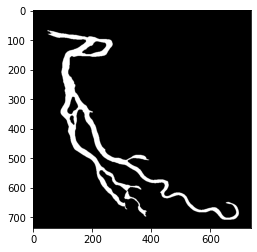

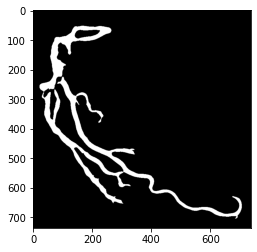

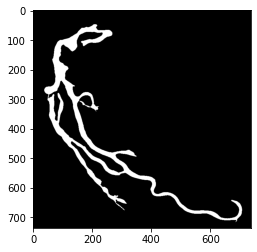

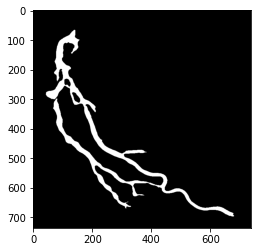

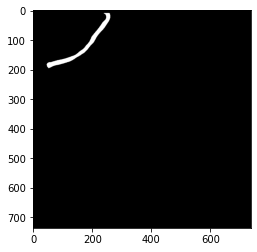

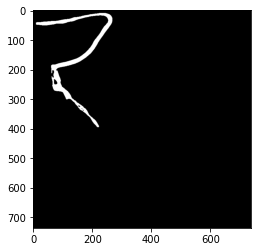

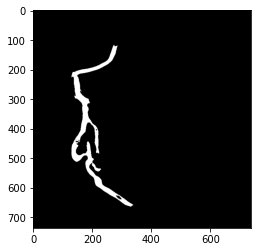

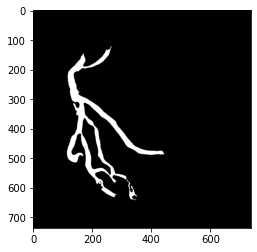

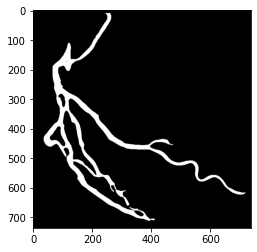

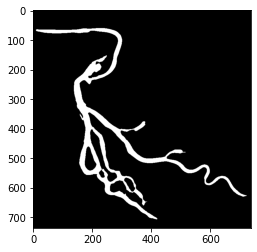

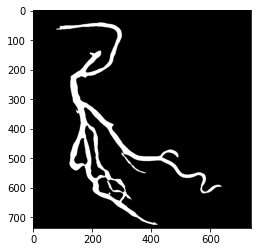

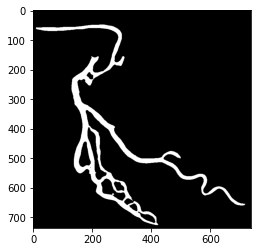

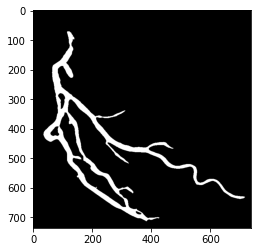

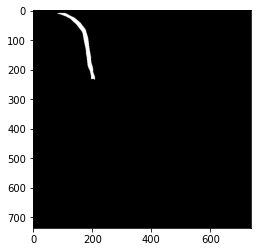

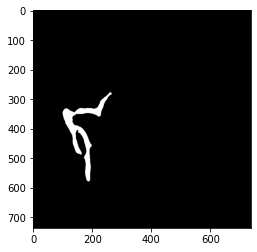

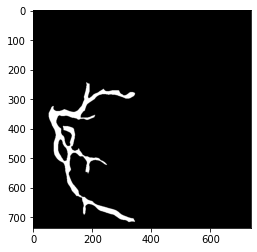

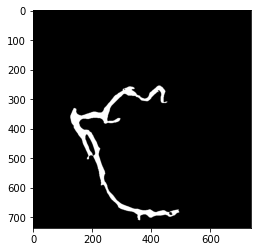

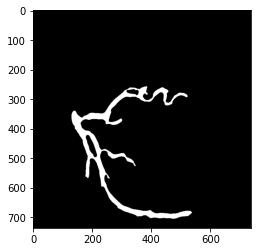

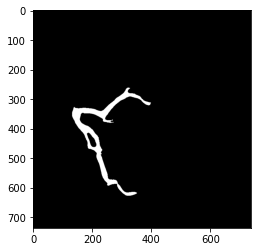

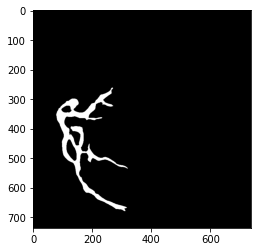

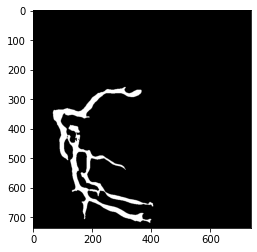

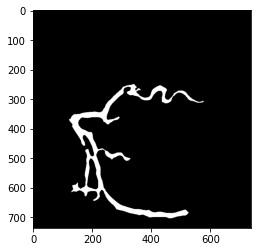

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from natsort import natsorted

path_to_grey_img = r"greyscale"
path_to_grey_seg = r"greyscale_out"

val_samples = 10
random.seed(1234)
#val_idx = random.sample(range(0,len(segs)),val_samples) 
#val_images = [images[idx] for idx in val_idx]
#val_masks =   [segs[idx] for idx in val_idx]
#val_files = [{"img": img, "seg": seg}
              #for img, seg in zip(val_images, val_masks)]



test = iter(test_loader)



def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

for i, data in enumerate(test):
  img = data
  imshow(torchvision.utils.make_grid(list(img.values())[0]))
  imshow(torchvision.utils.make_grid(list(img.values())[1]))
  if (i == 3):
    break
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64, 128, 256), #16, 32, 64....
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

model.load_state_dict(torch.load(
    "ALL_4l_rotFlip_1000epochs.pth"))
threshold = 0.5
model.eval()
test_iter = iter(test_loader)
for i, data in enumerate(test_iter):
  img, label = data["img"].to(
                device), data["seg"].to(device) 
  #output = model(torch.cuda.FloatTensor(list(img.values())[0]))
  output = model(img)
  val_outputs = [post_trans(i) for i in decollate_batch(output)]
  val_outputs = val_outputs[0][0].cpu()
  #print(val_outputs)
  plt.figure()
  plt.imshow((val_outputs>threshold), cmap = "gray")
  #break

#plt.figure()
#plt.imshow((val_outputs[0][0]), cmap = "gray")